In [1]:
import numpy as np
import matplotlib.pyplot as plt

from covapt_mt.covapt import covariance_model

In [8]:
pk_galaxy_file = "/home/joeadamo/Research/SPHEREx/covapt_mt/data/ps_for_Robin.npy"
pk_galaxy_dir = "/home/joeadamo/Research/SPHEREx/covapt_mt/data/"
window_dir = "/home/joeadamo/Research/SPHEREx/covapt_mt/data/Wij_k200_for_Robin.npy"
k = np.loadtxt(pk_galaxy_dir+"k_FS.dat")
# P0 = np.loadtxt(pk_galaxy_dir+"P0_FS.dat")
# P2 = np.loadtxt(pk_galaxy_dir+"P2_FS.dat")
# P4 = np.loadtxt(pk_galaxy_dir+"P4_FS.dat")
# pk_galaxy = np.vstack([P0, P2, P4])
# pk_galaxy = pk_galaxy.reshape((1, 1, pk_galaxy.shape[0], pk_galaxy.shape[1]))
#np.save(pk_galaxy_dir+"ps_for_Robin.npy", pk_galaxy)

n_galaxy = np.array([3e-4])
alpha = 1.

model = covariance_model(2, 2, n_galaxy, alpha, k, window_dir)
model.load_power_spectrum(pk_galaxy_file)

print(model.alpha_mt)
print(model.pk_galaxy.shape)

[[1.]]
(1, 1, 1, 5, 200)


In [9]:
C_G = model.get_mt_gaussian_covariance()
P_G = np.zeros_like(C_G)
for z in range(model.num_zbins):
    P_G[z] = np.linalg.inv(C_G[z])

In [10]:
def CorMat(cov):
    rms = np.sqrt(np.diag(cov))
    cor = np.copy(cov)
    for i in range(cov.shape[0]):
        for j in range(cov.shape[0]):
            cor[i,j] = cov[i,j]/(rms[i]*rms[j])
    return cor

ERROR! Covariance matrix is not positive definite!


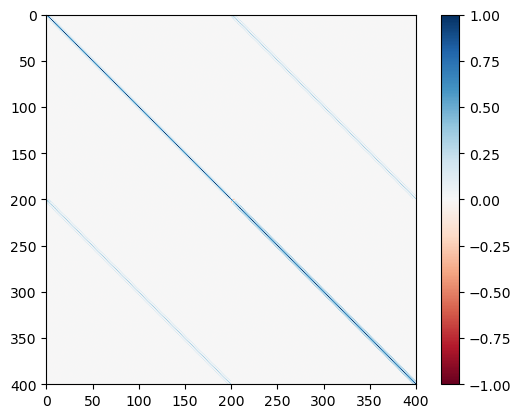

In [11]:
for z in range(model.num_zbins):

    try:
        L = np.linalg.cholesky(C_G[z])
        print("Covariance matrix is positive definite! :)")
    except:
        print("ERROR! Covariance matrix is not positive definite!")
        
    plt.figure()
    corr = CorMat(C_G[z])
    img = plt.imshow(corr, vmin=-1, vmax=1, cmap="RdBu")
    for i in range(model.num_spectra):
        plt.axvline(i*model.num_kbins*2 - 1, c="black", alpha=0.2)
        plt.axhline(i*model.num_kbins*2 - 1, c="black", alpha=0.2)
    plt.xlim(0, model.num_spectra*2*model.num_kbins)
    plt.ylim(model.num_spectra*2*model.num_kbins, 0)
    plt.colorbar()

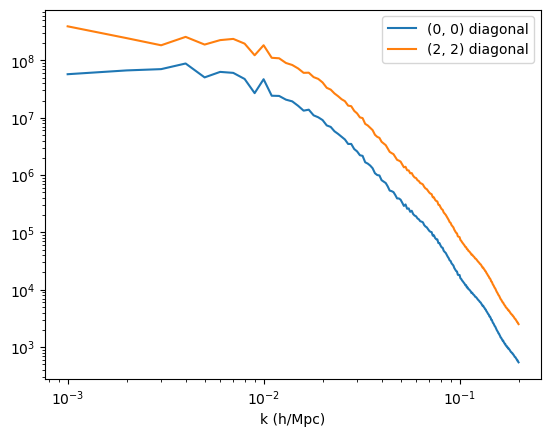

In [12]:
plt.plot(k, np.diag(C_G[0])[:len(k)], label="(0, 0) diagonal")
plt.plot(k, np.diag(C_G[0])[len(k):], label="(2, 2) diagonal")
plt.xscale("log")
plt.yscale("log")

plt.xlabel("k (h/Mpc)")
plt.legend()

there are 1 negative eigenvalues!


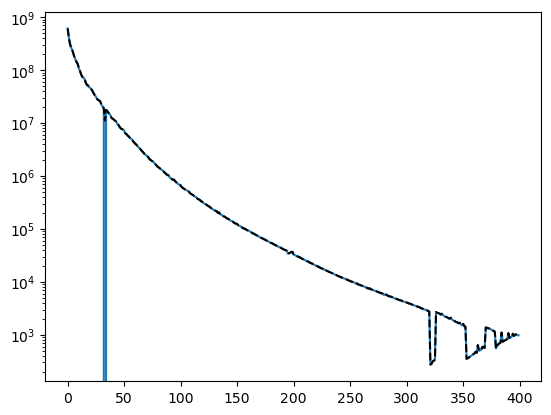

In [13]:
for z in range(model.num_zbins):
    eigvals, __ = np.linalg.eig(C_G[z])
    
    print("there are {:0.0f} negative eigenvalues!".format(len(eigvals[(eigvals < 0)])))
    plt.figure()
    plt.plot(eigvals)
    plt.plot(abs(eigvals), c="black", ls="--")
    plt.yscale("log")

In [16]:
np.save("/home/joeadamo/Research/SPHEREx/covapt_mt/data/cov_FS_Robin.npy", C_G)
#np.save("/home/joeadamo/Research/SPHEREx/spherex_emu/data/cov_2_sample_2_redshift/invcov.npy", P_G)

In [11]:
import torch
invcov_pytorch = torch.from_numpy(P_G)

np.save("/home/joeadamo/Research/Data/SPHEREx-Data/Training-Set-EFT-2s-2z/invcov.dat", invcov_pytorch)